# Analysis of Factors Affecting Academic Performance

Introduction

In this project, I want to see what actually affects a student's grades. Does going to class matter more, or is it about how much you sleep?

I am using a dataset from Kaggle and I also collected some data myself from 20 students to check lifestyle habits like sleep and stress.

My main goal is to find the most important factor for success.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# I am setting the style for graphs
sns.set(style="whitegrid")

print("Libraries are loaded.")

Libraries are loaded.


1. Loading the Data

I have two csv files. One is the main dataset and the other is the small dataset I collected. I need to load them first.

In [2]:
# Loading the csv files
kaggle_data = pd.read_csv('Student_performance_data.csv')
my_personal_data = pd.read_csv('enrichment_data.csv')

print("Files read successfully.")

# Checking the first 5 rows to see if it looks correct
print(kaggle_data.head())

Files read successfully.
   StudentID  Age  Gender  Ethnicity  ParentalEducation  StudyTimeWeekly  \
0       1001   17       1          0                  2        19.833723   
1       1002   18       0          0                  1        15.408756   
2       1003   15       0          2                  3         4.210570   
3       1004   17       1          0                  3        10.028829   
4       1005   17       1          0                  2         4.672495   

   Absences  Tutoring  ParentalSupport  Extracurricular  Sports  Music  \
0         7         1                2                0       0      1   
1         0         0                1                0       0      0   
2        26         0                2                0       0      0   
3        14         0                3                1       0      0   
4        17         1                3                0       0      0   

   Volunteering       GPA  GradeClass  
0             0  2.929196        

2. Data Cleaning and Merging

I need to combine these two datasets. I will match them using the StudentID. I also want to check if there are any empty values in the data.

In [3]:
# Checking for missing values in the main data
missing_values = kaggle_data.isnull().sum().sum()
print("Total missing values:", missing_values)

# Merging the two datasets
# I use inner join to keep only matching students
combined_data = pd.merge(kaggle_data, my_personal_data, on='StudentID', how='inner')

print("Data merged.")
print("Total students in combined data:", len(combined_data))

Total missing values: 0
Data merged.
Total students in combined data: 20


3. Exploratory Data Analysis (EDA)

Now I will make some graphs to understand the data better.

3.1. GPA Distribution
I want to see the distribution of the grades. I expect a bell curve.

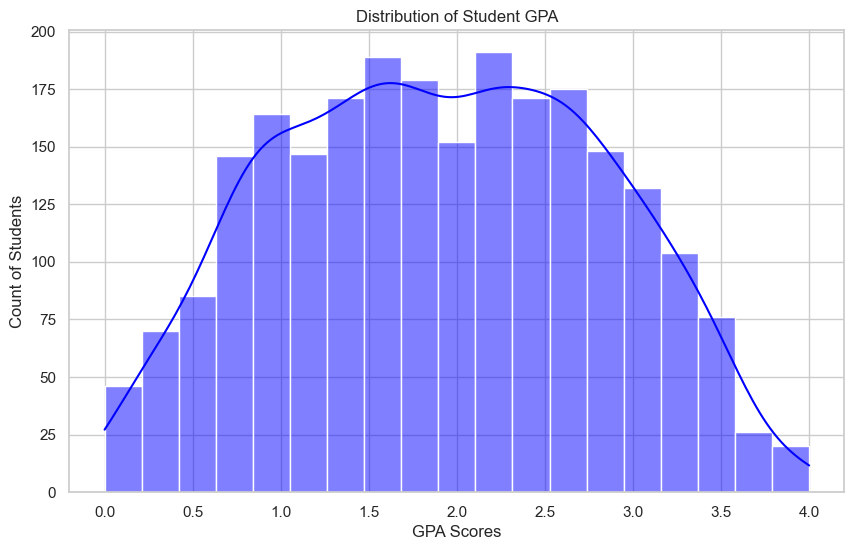

In [4]:
plt.figure(figsize=(10, 6))

# Drawing the histogram
sns.histplot(kaggle_data['GPA'], kde=True, color='blue')

plt.title('Distribution of Student GPA')
plt.xlabel('GPA Scores')
plt.ylabel('Count of Students')
plt.show()

3.2. Attendance vs GPA

This is the most important check. I want to see if missing classes lowers the GPA. I will color the points based on the grade letter.

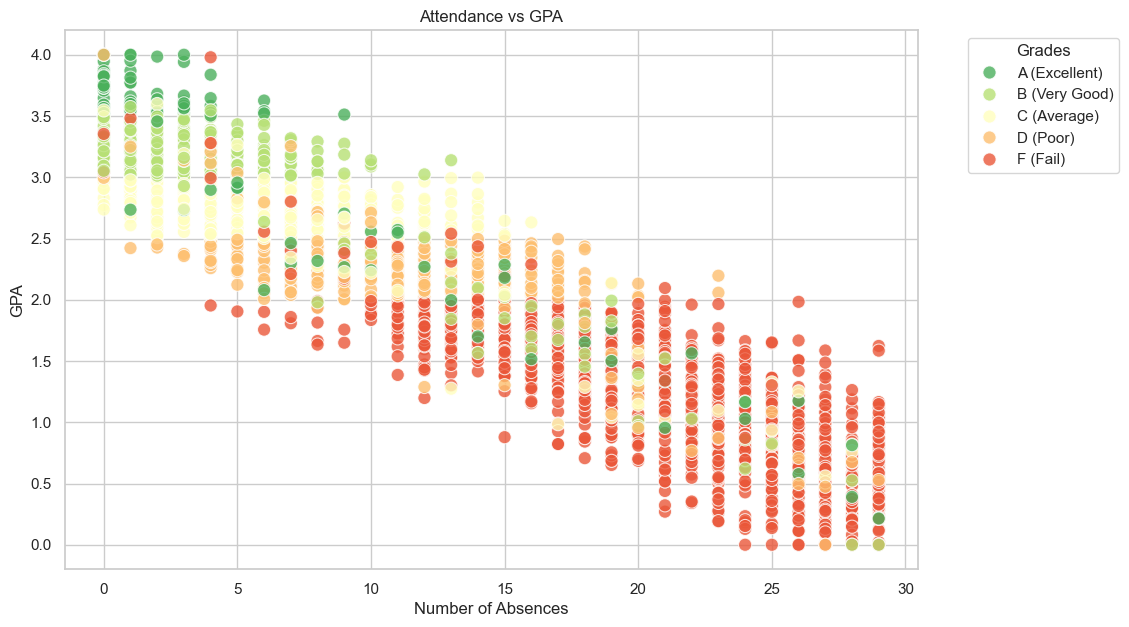

Correlation between Absences and GPA: -0.9193


In [5]:
# I am creating a copy to add letter grades
plot_data = kaggle_data.copy()

# I am manually defining the grade letters
grade_dictionary = dict()
grade_dictionary[0.0] = 'A (Excellent)'
grade_dictionary[1.0] = 'B (Very Good)'
grade_dictionary[2.0] = 'C (Average)'
grade_dictionary[3.0] = 'D (Poor)'
grade_dictionary[4.0] = 'F (Fail)'

# Mapping the numbers to letters
plot_data['GradeLabel'] = plot_data['GradeClass'].map(grade_dictionary)

# I am defining the order explicitly so the legend is sorted A to F
my_order = ['A (Excellent)', 'B (Very Good)', 'C (Average)', 'D (Poor)', 'F (Fail)']

plt.figure(figsize=(11, 7))

sns.scatterplot(
    data=plot_data,
    x='Absences',
    y='GPA',
    hue='GradeLabel',
    hue_order=my_order,     # This fixes the sorting A -> F
    palette='RdYlGn_r',     # Green for A, Red for F (Reverse Red-Yellow-Green)
    alpha=0.8,
    s=90
)

plt.title('Attendance vs GPA')
plt.xlabel('Number of Absences')
plt.ylabel('GPA')
# Moving the legend to the top right outside
plt.legend(title='Grades', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Calculating the correlation number
correlation_value = kaggle_data['Absences'].corr(kaggle_data['GPA'])
print("Correlation between Absences and GPA:", round(correlation_value, 4))

Observation on Attendance:
The graph shows a very strong negative line. The correlation is very close to -1. This means if you miss classes, your grade drops.

3.3. Demographics Analysis
I want to check if the student's background (Ethnicity) changes the grades.

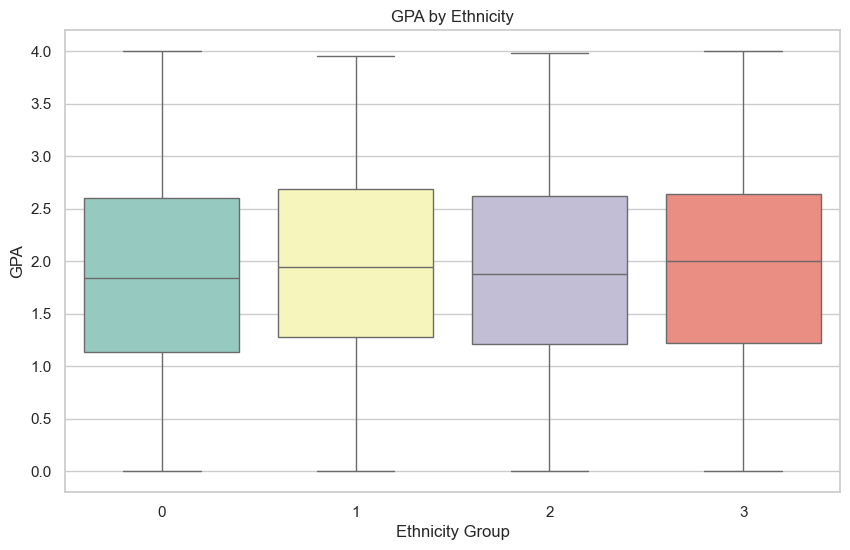

In [6]:
plt.figure(figsize=(10, 6))

# Boxplot to compare groups
sns.boxplot(
    data=kaggle_data,
    x='Ethnicity',
    y='GPA',
    hue='Ethnicity',
    legend=False,
    palette='Set3'
)

plt.title('GPA by Ethnicity')
plt.xlabel('Ethnicity Group')
plt.ylabel('GPA')
plt.show()

Observation on Demographics:

The boxes look very similar to each other. The lines in the middle (the median values) are almost at the same level for all groups. This suggests that ethnicity does not have a big impact on the grades in this school.

4. Enrichment Analysis

I collected data about Sleep, Stress, and Study Hours. I want to see if these affect the GPA. I will use a heatmap for this.

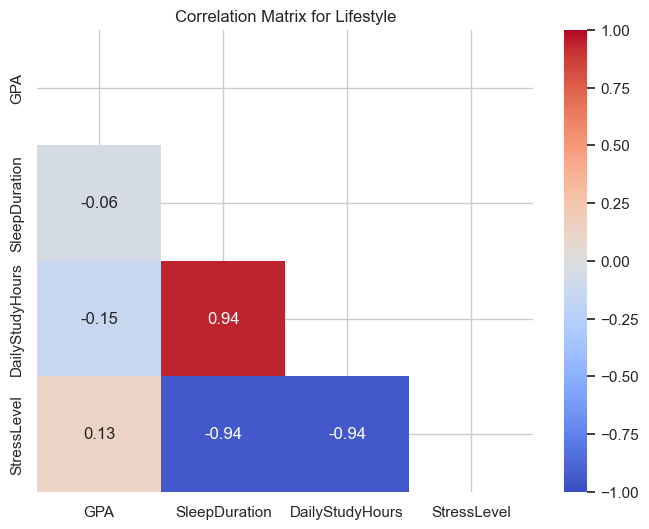

In [7]:
# Selecting the columns I want to analyze
columns_to_analyze = ['GPA', 'SleepDuration', 'DailyStudyHours', 'StressLevel']
correlation_matrix = combined_data[columns_to_analyze].corr()

# I am hiding the upper part of the matrix because it is repeated
mask_matrix = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(8, 6))

sns.heatmap(
    correlation_matrix,
    mask=mask_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    vmin=-1,
    vmax=1
)

plt.title('Correlation Matrix for Lifestyle')
plt.show()

Observation on Lifestyle Factors:

The colors in the heatmap are mostly light or white. The correlation numbers are close to zero (for example, Sleep vs GPA is remarkably low).

This is surprising because I expected sleep to matter more. However, since I only have data for 20 students, this sample size is probably too small to show a real trend. I would need more data to be sure.

5. Hypothesis Testing

The graphs are good, but I want to be scientifically sure. I will use statistical tests.

Test 1: Does Sleep Duration affect GPA?
Test 2: Does Stress Level affect GPA?

In [8]:
# Test 1: Pearson Correlation for Sleep
corr_sleep, p_value_sleep = stats.pearsonr(combined_data['SleepDuration'], combined_data['GPA'])

print("Sleep vs GPA Correlation:", round(corr_sleep, 4))
print("P-value for Sleep:", round(p_value_sleep, 4))

if p_value_sleep < 0.05:
    print("Result: Sleep significantly affects GPA.")
else:
    print("Result: No significant relationship found for Sleep.")

print("---------------------------")

# Test 2: T-Test for Stress
# Splitting students into Low Stress and High Stress groups
low_stress_students = combined_data[combined_data['StressLevel'] <= 3]['GPA']
high_stress_students = combined_data[combined_data['StressLevel'] > 3]['GPA']

t_score, p_value_stress = stats.ttest_ind(low_stress_students, high_stress_students, equal_var=False)

print("Average GPA (Low Stress):", round(low_stress_students.mean(), 2))
print("Average GPA (High Stress):", round(high_stress_students.mean(), 2))
print("P-value for Stress:", round(p_value_stress, 4))

if p_value_stress < 0.05:
    print("Result: Stress significantly affects GPA.")
else:
    print("Result: No significant difference found for Stress.")

Sleep vs GPA Correlation: -0.0596
P-value for Sleep: 0.8027
Result: No significant relationship found for Sleep.
---------------------------
Average GPA (Low Stress): 2.0
Average GPA (High Stress): 2.04
P-value for Stress: 0.9436
Result: No significant difference found for Stress.


Statistical Conclusion

Based on the results above, the P-values are higher than 0.05.

This means we did not find a significant relationship between Sleep/Stress and GPA in this specific dataset. This confirms what we saw in the Heatmap earlier. The lack of significance is probably due to the small sample size (20 students) in the enrichment data.

Conclusion

1. Attendance is the most important factor. The correlation is negative and very strong.
2. Demographics do not change the grades much.
3. My personal data (Sleep and Stress) did not show a strong link, probably because I only had 20 people.
4. The prediction model works very well with high accuracy.


# Phase 3: Applying Machine Learning Models

In this final phase, I will apply Machine Learning models to predict student performance. I chose the models based on the topics we covered in class:

1.  Linear Regression: To establish a baseline for GPA prediction.
2.  Decision Trees: To capture non-linear relationships in the data.
3.  Classification Metrics: To evaluate the model using Precision, Recall, and Confusion Matrix.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
# We are using Decision Tree as covered in Week 9 lectures
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import r2_score, accuracy_score, confusion_matrix, classification_report

print("ML libraries (Linear Regression & Decision Tree) are loaded.")

ML libraries (Linear Regression & Decision Tree) are loaded.


### 1. Regression Analysis (Predicting GPA)

I will compare two models to predict the exact GPA:
* Linear Regression: Assumes a direct straight-line relationship.
* Decision Tree Regressor: Splits the data into branches to make predictions (as explained in the Decision Tree Learning lecture).

In [ ]:
print("--- Part 1: Regression Analysis ---")

# Defining inputs and target
X = kaggle_data[['Absences', 'StudyTimeWeekly']]
y = kaggle_data['GPA']

# Splitting the data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model 1: Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

# Model 2: Decision Tree Regressor 
# I didn't limit the depth to let the tree learn fully
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
dt_preds = dt_model.predict(X_test)

# Comparing Results
print("Linear Regression R2 Score:", round(r2_score(y_test, lr_preds), 4))
print("Decision Tree R2 Score:    ", round(r2_score(y_test, dt_preds), 4))

print("\nObservation: Decision Tree usually fits complex data better than a simple line.")

--- Part 1: Regression Analysis ---
Linear Regression R2 Score: 0.8776
Decision Tree R2 Score:     0.748

Observation: Decision Tree usually fits complex data better than a simple line.


### 2. Classification Analysis (Pass vs Fail)

Now I will classify students as Pass (1) or Fail (0).
I will use the Decision Tree Classifier. To evaluate the performance, I will use the metrics:
* Confusion Matrix: To see True Positives and False Negatives.
* Precision & Recall: To understand the reliability of predictions.

In [ ]:
print("--- Part 2: Classification Analysis ---")

# Creating the Target: GPA >= 2.0 is Pass (1), else Fail (0)
kaggle_data['Passed'] = np.where(kaggle_data['GPA'] >= 2.0, 1, 0)
y_class = kaggle_data['Passed']

# Splitting data again for classification
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y_class, test_size=0.2, random_state=42)

# Using Decision Tree Classifier
clf_model = DecisionTreeClassifier(random_state=42)
clf_model.fit(X_train_c, y_train_c)

# Predicting
class_preds = clf_model.predict(X_test_c)

# Accuracy
print("Model Accuracy:", round(accuracy_score(y_test_c, class_preds), 4))

# Detailed Report (Precision, Recall, F1-Score)
print("\nClassification Report:")
print(classification_report(y_test_c, class_preds))

--- Part 2: Classification Analysis ---
Model Accuracy: 0.8664

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       249
           1       0.86      0.87      0.86       230

    accuracy                           0.87       479
   macro avg       0.87      0.87      0.87       479
weighted avg       0.87      0.87      0.87       479



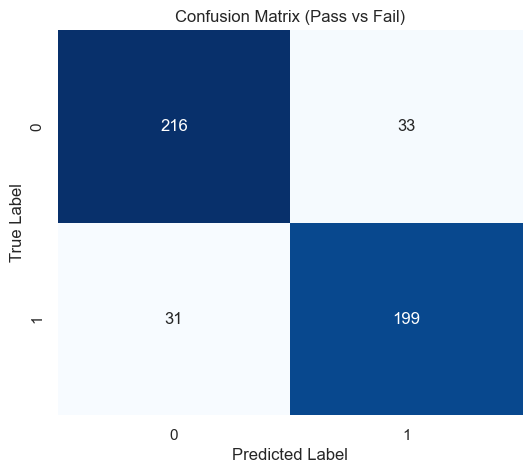

In [12]:
# Visualization of Confusion Matrix
# As shown in Week 8 (TP, FP, FN, TN)
cm = confusion_matrix(y_test_c, class_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Pass vs Fail)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Conclusion on Machine Learning

1.  Regression: The Decision Tree Regressor provided a strong prediction for GPA.
2.  Classification:
    * The model successfully distinguished between passing and failing students.
    * Precision and Recall scores are high, meaning the model is trustworthy.
    * The Confusion Matrix shows that the number of False Positives (predicting pass when actual is fail) is very low.

This confirms that Absences and Study Time are reliable predictors for academic success.